# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers? 
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd

In [2]:
# read the sports vouchers data
vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '').str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


In [4]:
uniques = pd.unique(seifa[["INDEX_TYPE", "Index Type"]].values.ravel())
pd.DataFrame(uniques)

,0
0,IRSAD
1,Index of Relative Socio-economic Advantage and...
2,IRSD
3,Index of Relative Socio-economic Disadvantage
4,IER
5,Index of Economic Resources
6,IEO
7,Index of Education and Occupation


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [5]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


In [6]:
LGA_scores_SA = LGA_scores[LGA_scores.index.isin(vouchers["Participant_LGA"])]
LGA_scores_SA.sort_values(by='IRSAD', ascending=False).head(10)

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
BURNSIDE,1044.0,1044.0,1090.0,1081.0,42168.0
ROXBY DOWNS,1066.0,1066.0,1086.0,1096.0,4694.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
WALKERVILLE,1029.0,1029.0,1076.0,1065.0,7008.0
UNLEY,1013.0,1013.0,1071.0,1065.0,36813.0
MITCHAM,1041.0,1041.0,1068.0,1068.0,62912.0
PROSPECT,997.0,997.0,1040.0,1042.0,19950.0
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
HOLDFAST BAY,991.0,991.0,1034.0,1039.0,34646.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [7]:
vouchers_scores = vouchers.join(LGA_scores, on='Participant_LGA')
vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [8]:
#Top 10 LGA by Voucher utilized
pd.DataFrame(vouchers_scores.groupby(by="Participant_LGA")["Participant_LGA"].count().sort_values(ascending=False)).head(10)

,Participant_LGA
Participant_LGA,
ONKAPARINGA,12782
SALISBURY,8169
TEA TREE GULLY,7219
PLAYFORD,6940
CHARLES STURT,6897
PORT ADELAIDE ENFIELD,6384
MARION,5291
ADELAIDE HILLS,4756
MITCHAM,4662


The table above shows top 10 LGA by number of vouchers utilized. Most of the LGA are within metropolitan region.

In [9]:
#Bottom 10 LGA by Voucher utilized
pd.DataFrame(vouchers_scores.groupby(by="Participant_LGA")["Participant_LGA"].count().sort_values(ascending=True)).head(10)

,Participant_LGA
Participant_LGA,
COOBER PEDY,39
PETERBOROUGH,45
FLINDERS RANGES,102
ORROROO/CARRIETON,137
FRANKLIN HARBOUR,155
ELLISTON,165
ROBE,167
MOUNT REMARKABLE,205
KIMBA,232


The table above shows bottom 10 LGA by number of vouchers utilized. These LGAs are mostly located in remote regional area.

In [10]:
lga_gdf = gpd.read_file('files/SA_LGA_POLYGON_SHP.shp') #load the data using Geopandas
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME']
lga_gdf.loc[(lga_gdf['LGA_NAME']=='THE DC OF ORROROO CARRIETON'),'LGA_NAME_Updated'] = 'ORROROO/CARRIETON'
lga_gdf.loc[(lga_gdf['LGA_NAME']=='COORONG DISTRICT COUNCIL'),'LGA_NAME_Updated'] = 'THE COORONG'
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' CITY COUNCIL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' COUNCIL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('THE ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('CITY OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('THE DC OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' DISTRICT COUNCIL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' DC','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('THE RURAL ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('THE CORPORATION OF THE ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('THE REGIOAL COUNCIL OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('DC OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' REGIONAL COUNCIL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('MUNICIPAL COUNCIL OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('TOWN OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('REGIONAL OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' REGIONAL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' DISTRICT','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('RURAL ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace(' REGIONAL','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('MUNICIPAL OF ','')
lga_gdf['LGA_NAME_Updated'] = lga_gdf['LGA_NAME_Updated'].str.replace('CORPORATION OF ','')

In [11]:
LGA_Sport_4map = pd.DataFrame(vouchers_scores.groupby(by="Participant_LGA")["Participant_LGA"].count())
LGA_Sport_4map.index.rename('index', inplace=True)
LGA_Sport_4map.reset_index(inplace=True)
LGA_Sport_4map.rename(columns = {'index':'Participant_LGA','Participant_LGA':'count'}, inplace = True)
df_merged = lga_gdf.merge(LGA_Sport_4map, left_on=['LGA_NAME_Updated'], right_on=['Participant_LGA'], how = 'left')

<AxesSubplot:>

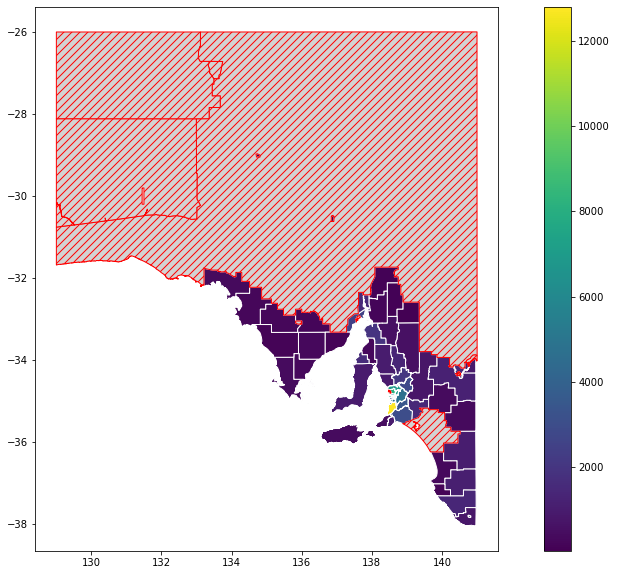

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(15,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
df_merged.plot(column='count',  linewidth=1, ax=ax, edgecolor='1', legend = True, cax=cax,
              missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values",})

Voucher utilization data plot into SA LGA map. We can see the high voucher usage is mainly form Adelaide metro area. Most of the regional LGA voucher usage data is missing. The missing LGA are shaded with red lines.

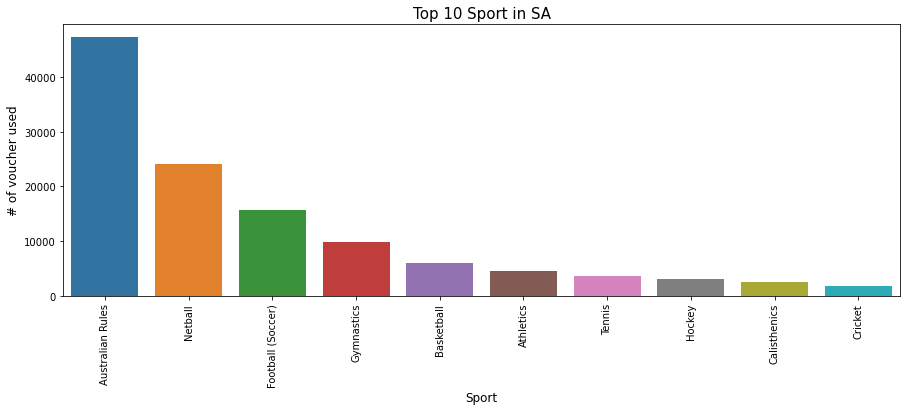

In [13]:
#Top 10 Sport in SA

Top_10_Sport = vouchers_scores.groupby(by = "Voucher_Sport")["Voucher_Sport"].count().sort_values(ascending=False).reset_index(name ='Voucher_Used').head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Voucher_Sport',
              y='Voucher_Used',
              data=Top_10_Sport)
 
# Rotate x-labels
var = plt.xticks(rotation='vertical')
plt.xlabel('Sport', fontsize=12)
plt.ylabel('# of voucher used', fontsize=12)
plt.title('Top 10 Sport in SA', fontsize=15)
plt.show()


Australian Rules, Netball, Football (Soccer), Gymnastics and Basketball are the 5 top sport by number of vouchers utilized in whole SA.

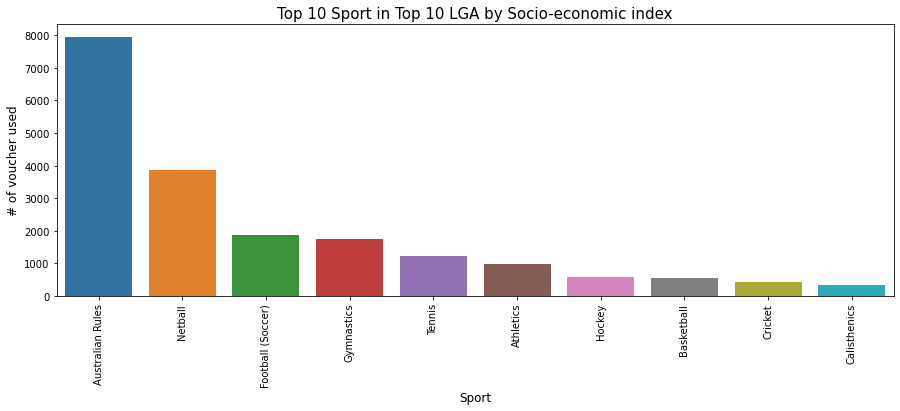

In [14]:
#Top 10 Sport in Top 10 LGA

Top_10_LGA_sport = vouchers_scores[vouchers_scores["Participant_LGA"].isin(LGA_scores_SA.sort_values(by='IRSAD', ascending=False).head(10).index)].groupby(by = "Voucher_Sport")["Voucher_Sport"].count().sort_values(ascending=False).reset_index(name ='Voucher_Used').head(10)

plt.figure(figsize=(15,5))
p = sns.barplot(x='Voucher_Sport',
              y='Voucher_Used',
              data=Top_10_LGA_sport)
 
# Rotate x-labels
var = plt.xticks(rotation='vertical')
plt.title('Top 10 Sport in Top 10 LGA by Socio-economic index', fontsize=15)
plt.xlabel('Sport', fontsize=12)
plt.ylabel('# of voucher used', fontsize=12)
plt.show()

When we focus on top 10 LGA by Socio-economic index, we can see top 4 favourate sport are remain same as the whole SA.

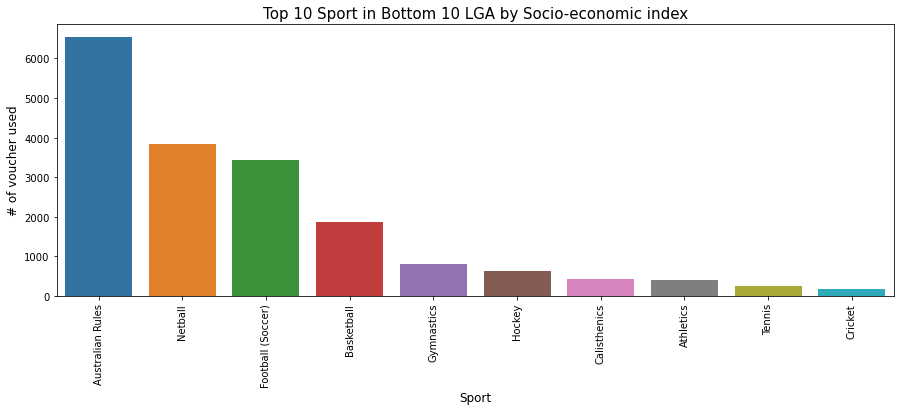

In [15]:
#Top 10 Sport in Bottom 10 LGA

Bottom_10_LGA = vouchers_scores[vouchers_scores["Participant_LGA"].isin(LGA_scores_SA.sort_values(by='IRSAD', ascending=True).head(10).index)].groupby(by = "Voucher_Sport")["Voucher_Sport"].count().sort_values(ascending=False).reset_index(name ='Voucher_Used').head(10)

plt.figure(figsize=(15,5))
p = sns.barplot(x='Voucher_Sport',
              y='Voucher_Used',
              data=Bottom_10_LGA)
 
# Rotate x-labels
var = plt.xticks(rotation='vertical')
plt.title('Top 10 Sport in Bottom 10 LGA by Socio-economic index', fontsize=15)
plt.xlabel('Sport', fontsize=12)
plt.ylabel('# of voucher used', fontsize=12)
plt.show()

Bottom 10 LGA by Socio-economic index also have top 3 favorite sport same as the whole SA. Australian Rules, Netball, Football are the most favorite sport across the SA regardless the Socio-economic index.

In [16]:
vouchers_scores_LGA = vouchers_scores.groupby(by=["Participant_LGA","IRSAD"]).agg({"Participant_ID": ['count']}).reset_index()
vouchers_scores_LGA.columns = ["Participant_LGA", "IRSAD", "Voucher used"]
vouchers_scores_LGA1 = vouchers_scores_LGA.copy()
vouchers_scores_LGA1 = vouchers_scores_LGA1.drop("Participant_LGA",axis=1)
scaler = MinMaxScaler()
vouchers_scores_LGA_trans = pd.DataFrame(scaler.fit_transform(vouchers_scores_LGA1))
vouchers_scores_LGA_trans.columns = ["IRSAD", "Voucher used"]
vouchers_scores_LGA_trans = vouchers_scores_LGA_trans.sort_values(by=["Voucher used"]).reset_index()

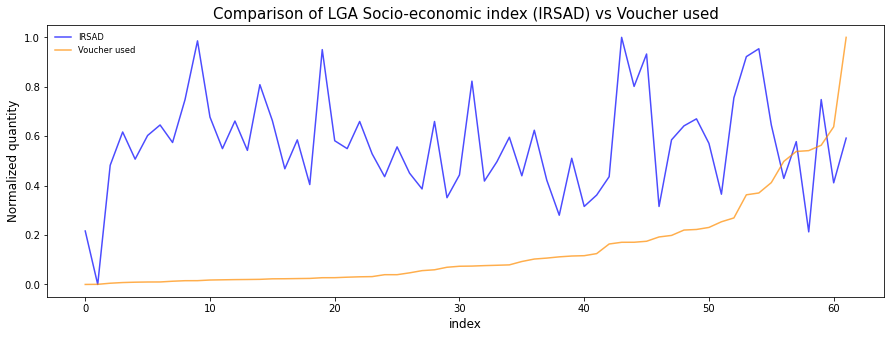

In [17]:
plt.figure(figsize=(15,5))
plt.plot(vouchers_scores_LGA_trans.index, vouchers_scores_LGA_trans["IRSAD"], label = "IRSAD",color = "blue", alpha = 0.7)
plt.plot(vouchers_scores_LGA_trans.index, vouchers_scores_LGA_trans["Voucher used"], label = "Voucher used",color = "darkorange", alpha = 0.7)
plt.legend(fontsize = "small", markerscale = 0.5, frameon = False)
plt.ylabel("Normalized quantity", fontsize=12)
plt.xlabel("index", fontsize=12)
plt.title("Comparison of LGA Socio-economic index (IRSAD) vs Voucher used", fontsize=15)
plt.show()

This plot shows the normalized quantities of vouchers used in orange line and Socio-economic index (IRSAD) in blue line. We can see some of the very high IRSAD index LGA has very low voucher usage. While the highest voucher utilized LGA has mid-level IRSAD index.

In [18]:
Active_LGA = vouchers_scores[vouchers_scores["Participant_LGA"].isin(vouchers_scores_LGA.sort_values(["Voucher used"], ascending=False).head(10)["Participant_LGA"])]
Active_LGA_agg = Active_LGA.groupby(by =  ["Participant_LGA","Voucher_Sport"]).agg({"Participant_ID": ['count']}).reset_index()
Active_LGA_agg.columns = Active_LGA_agg.columns.droplevel(1)
Active_LGA_Sorted = Active_LGA_agg.groupby(["Participant_LGA"]).apply(lambda x: x.sort_values(["Participant_ID"], ascending=False))
Active_LGA_Sorted = Active_LGA_Sorted.reset_index(drop=True)
Top_5_Sport_Active_LGA = Active_LGA_Sorted.groupby('Participant_LGA').head(5)

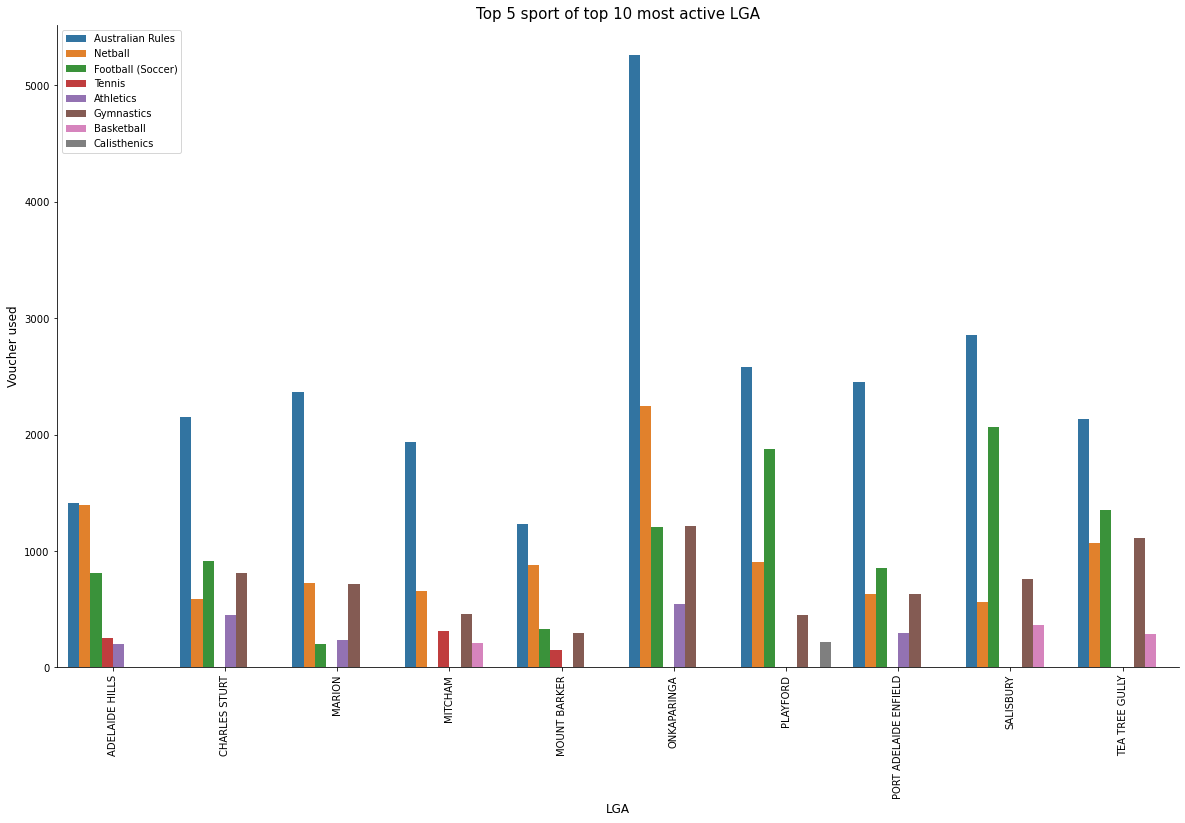

In [19]:
ax = sns.catplot(x='Participant_LGA', y='Participant_ID', hue='Voucher_Sport', data=Top_5_Sport_Active_LGA, kind='bar', legend= False)
plt.xticks(rotation='vertical')
plt.ylabel("Voucher used", fontsize=12)
plt.xlabel("LGA", fontsize=12)
plt.legend(loc='best')
ax.fig.set_size_inches(20,10)
plt.title("Top 5 sport of top 10 most active LGA", fontsize=15)
plt.show()

ONKAPARINGA is the most active LGA as utilized the most vouchers by a big margin to the next most active LGA. Tennis is not in top 5 sport in ONKAPARINGA unlike the whole state of SA.

In [20]:
Least_Active_LGA = vouchers_scores[vouchers_scores["Participant_LGA"].isin(vouchers_scores_LGA.sort_values(["Voucher used"], ascending=False).tail(10)["Participant_LGA"])]
Least_Active_LGA_agg = Least_Active_LGA.groupby(by =  ["Participant_LGA","Voucher_Sport"]).agg({"Participant_ID": ['count']}).reset_index()
Least_Active_LGA_agg.columns = Least_Active_LGA_agg.columns.droplevel(1)
Least_Active_LGA_Sorted = Least_Active_LGA_agg.groupby(["Participant_LGA"]).apply(lambda x: x.sort_values(["Participant_ID"], ascending=False))
Least_Active_LGA_Sorted = Least_Active_LGA_Sorted.reset_index(drop=True)
Top_5_Sport_Least_Active_LGA = Least_Active_LGA_Sorted.groupby('Participant_LGA').head(5)

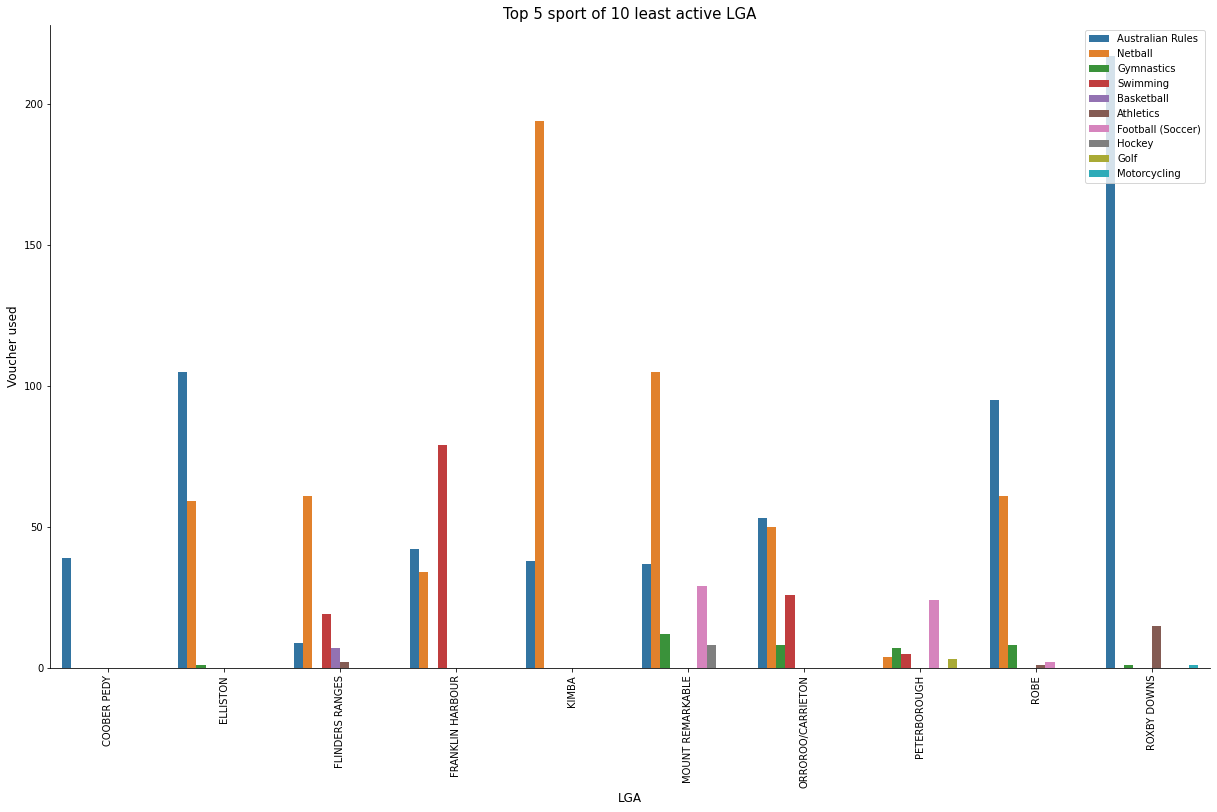

In [21]:
ax = sns.catplot(x='Participant_LGA', y='Participant_ID', hue='Voucher_Sport', data=Top_5_Sport_Least_Active_LGA, kind='bar', legend= False)
plt.xticks(rotation='vertical')
plt.ylabel("Voucher used", fontsize=12)
plt.xlabel("LGA", fontsize=12)
plt.legend(loc='best')
ax.fig.set_size_inches(20,10)
plt.title("Top 5 sport of 10 least active LGA", fontsize=15)
plt.show()

Least active LGA are mostly remote regional LGA. Australian Rules and Netball are the most popular sport in these least active LGA.

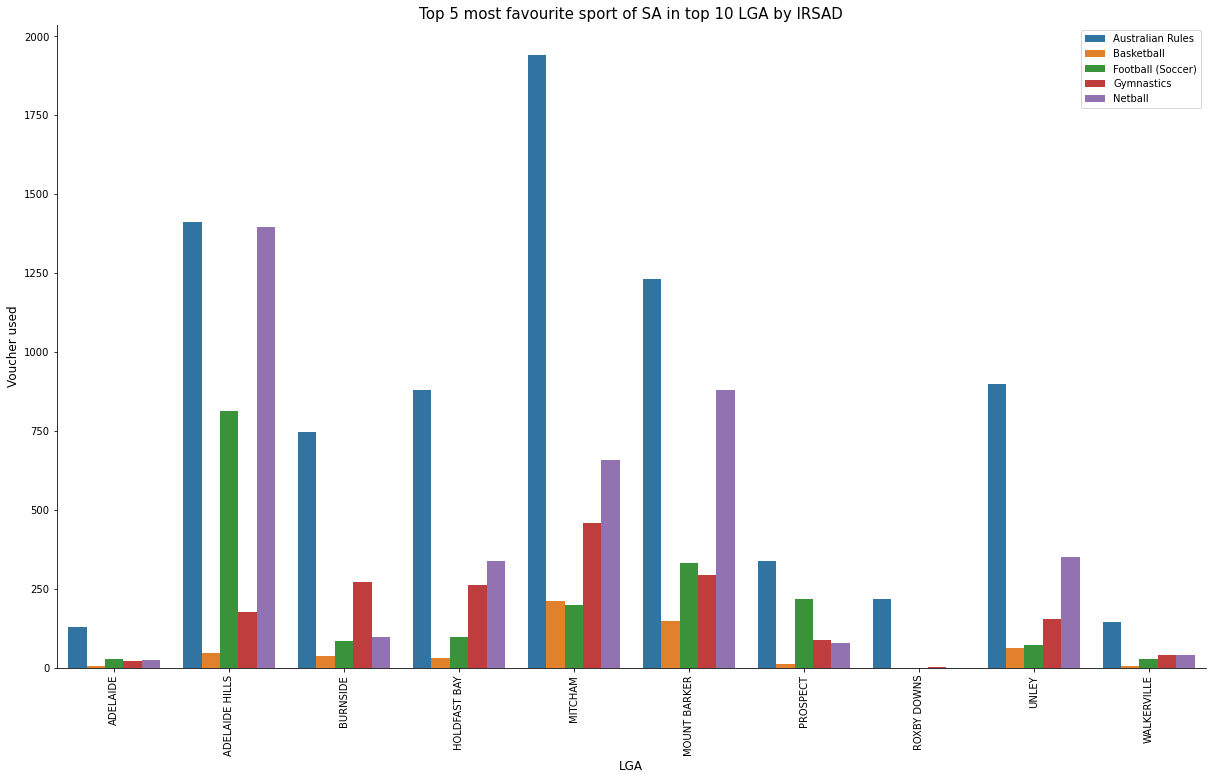

In [22]:
Top10_LGA = vouchers_scores[vouchers_scores["Participant_LGA"].isin(LGA_scores_SA.sort_values(by='IRSAD', ascending=False).head(10).index)]
Top10_LGA_Top_5_Sport = Top10_LGA[Top10_LGA["Voucher_Sport"].isin(Top_10_Sport['Voucher_Sport'].head(5))]
Top10_LGA_Top_5_Sport_group = Top10_LGA_Top_5_Sport.groupby(by =  ["Participant_LGA","Voucher_Sport"]).agg({"Participant_ID": ['count']}).reset_index()
Top10_LGA_Top_5_Sport_group.columns = Top10_LGA_Top_5_Sport_group.columns.droplevel(1)
ax = sns.catplot(x='Participant_LGA', y='Participant_ID', hue='Voucher_Sport', data=Top10_LGA_Top_5_Sport_group, kind='bar', legend= False)
plt.xticks(rotation='vertical')
plt.ylabel("Voucher used", fontsize=12)
plt.xlabel("LGA", fontsize=12)
plt.legend(loc='best')
ax.fig.set_size_inches(20,10)
plt.title("Top 5 most favourite sport of SA in top 10 LGA by IRSAD", fontsize=15)
plt.show()

The plot shows voucher utilized for top 5 most favourite sport of entire state SA from top 10 LGA by Socio-economic index (IRSAD). MITCHAM is most active LGA in these group. ADELAIDE, ROXBY DOWNS, WALKERVILLE LGA in these group are very less active.

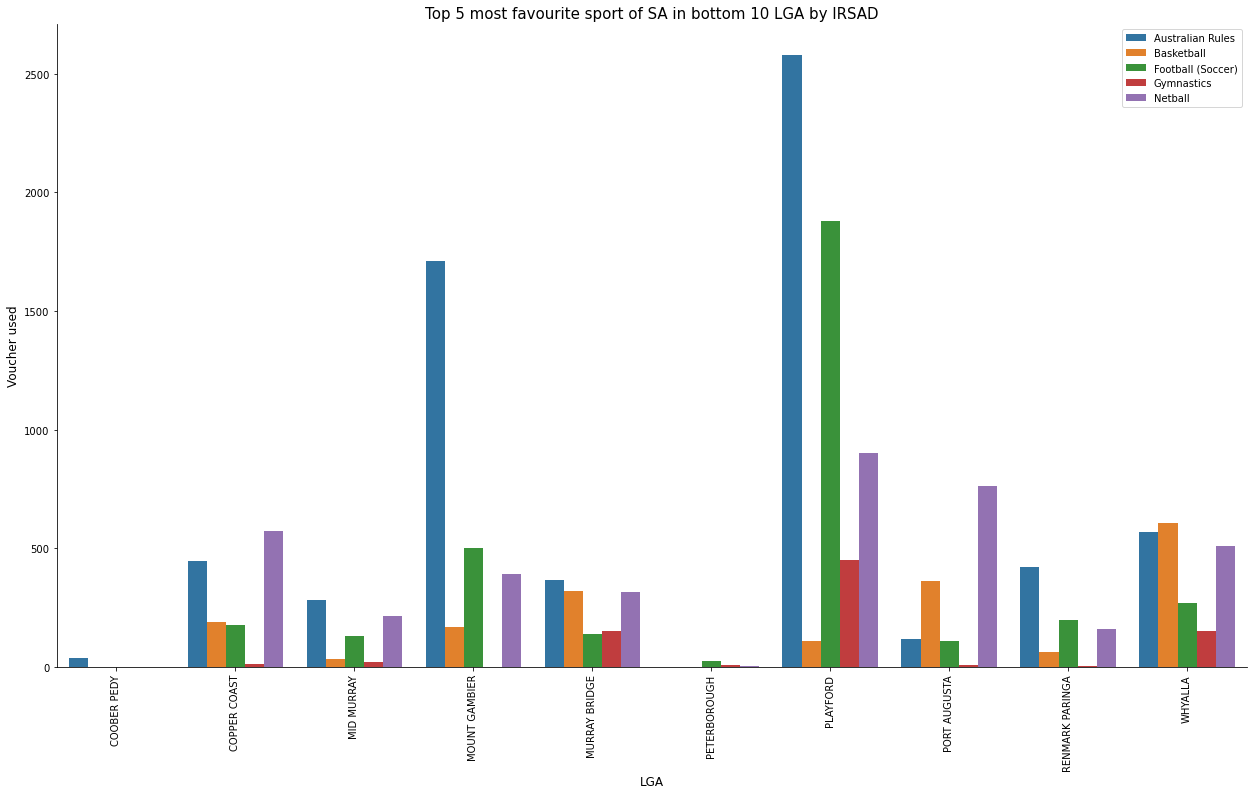

In [23]:
Bottom10_LGA = vouchers_scores[vouchers_scores["Participant_LGA"].isin(LGA_scores_SA.sort_values(by='IRSAD', ascending=True).head(10).index)]
Bottom10_LGA_Top_5_Sport = Bottom10_LGA[Bottom10_LGA["Voucher_Sport"].isin(Top_10_Sport['Voucher_Sport'].head(5))]
Bottom10_LGA_Top_5_Sport_group = Bottom10_LGA_Top_5_Sport.groupby(by =  ["Participant_LGA","Voucher_Sport"]).agg({"Participant_ID": ['count']}).reset_index()
Bottom10_LGA_Top_5_Sport_group.columns = Bottom10_LGA_Top_5_Sport_group.columns.droplevel(1)
ax = sns.catplot(x='Participant_LGA', y='Participant_ID', hue='Voucher_Sport', data=Bottom10_LGA_Top_5_Sport_group, kind='bar', legend= False)
plt.xticks(rotation='vertical')
plt.ylabel("Voucher used", fontsize=12)
plt.xlabel("LGA", fontsize=12)
plt.legend(loc='best')
ax.fig.set_size_inches(20,10)
plt.title("Top 5 most favourite sport of SA in bottom 10 LGA by IRSAD", fontsize=15)
plt.show()

The plot shows voucher utilized for top 5 most favourite sport of entire state SA from bottom 10 LGA by Socio-economic index (IRSAD). Most of these LGA are from remote regional places. PLAYFORD is most active LGA in this group.

Australian Rules, Netball and Football (Soccer) are most popular sort across the state of SA. Most of the active LGA are mid Socio-economic index (IRSAD). Most of the low Socio-economic index (IRSAD) LGA have very low voucher utilization. These LGA can be incentivize more to be more active.